# Using PyTorch with TensorRT through ONNX:

TensorRT is a great way to take a trained PyTorch model and optimize it to run more efficiently during inference on an NVIDIA GPU.

One approach to convert a PyTorch model to TensorRT is to export a PyTorch model to ONNX (an open format exchange for deep learning models) and then convert into a TensorRT engine. Essentially, we will follow this path to convert and deploy our model:

![PyTorch+ONNX](./images/pytorch_onnx.png)

Both TensorFlow and PyTorch models can be exported to ONNX, as well as many other frameworks. This allows models created using either framework to flow into common downstream pipelines.

To get started, let's take a well-known computer vision model and follow five key steps to deploy it to the TensorRT Python runtime:

1. __What format should I save my model in?__
2. __What batch size(s) am I running inference at?__
3. __What precision am I running inference at?__
4. __What TensorRT path am I using to convert my model?__
5. __What runtime am I targeting?__

## 1. What format should I save my model in?

We are going to use ResNet50, a widely used CNN architecture first described in <a href=https://arxiv.org/abs/1512.03385>this paper</a>.

Let's start by loading dependencies and downloading the model. We will also move our Resnet model onto the GPU and set it to evaluation mode.

In [1]:
import torchvision.models as models
import torch
import torch.onnx

# load the pretrained model
resnet50 = models.resnet50(pretrained=True, progress=False).eval()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


When saving a model to ONNX, PyTorch requires a test batch in proper shape and format. We pick a batch size:

In [2]:
BATCH_SIZE=32

dummy_input=torch.randn(BATCH_SIZE, 3, 224, 224)

Next, we will export the model using the dummy input batch:

In [3]:
# export the model to ONNX
torch.onnx.export(resnet50, dummy_input, "resnet50_pytorch.onnx", verbose=False)

Note that we are picking a BATCH_SIZE of 32 in this example.

### Now Test with a Real Image:

Let's try a real image batch! For this example, we will simply repeat one open-source dog image from http://www.dog.ceo:

In [4]:
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np

url='https://images.dog.ceo/breeds/retriever-golden/n02099601_3004.jpg'
img = resize(io.imread(url), (224, 224))
img = np.expand_dims(np.array(img, dtype=np.float32), axis=0) # Expand image to have a batch dimension
input_batch = np.array(np.repeat(img, BATCH_SIZE, axis=0), dtype=np.float32) # Repeat across the batch dimension

input_batch.shape

(32, 224, 224, 3)

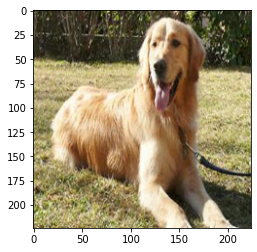

In [5]:
plt.imshow(input_batch[0].astype(np.float32))

In [6]:
resnet50_gpu = models.resnet50(pretrained=True, progress=False).to("cuda").eval()

We need to move our batch onto GPU and properly format it to shape [32, 3, 224, 224]. 

In [7]:
input_batch_chw = torch.from_numpy(input_batch).transpose(1,3).transpose(2,3)
input_batch_gpu = input_batch_chw.to("cuda")

input_batch_gpu.shape

torch.Size([32, 3, 224, 224])

We can run a prediction on a batch using .forward():

In [8]:
with torch.no_grad():
    predictions = np.array(resnet50_gpu(input_batch_gpu).cpu())

predictions.shape

(32, 1000)

### Verify Baseline Model Performance/Accuracy:

For a baseline, lets time our prediction in FP32:

In [9]:
%%timeit

with torch.no_grad():
    preds = np.array(resnet50_gpu(input_batch_gpu).cpu())

31.5 ms ± 72.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can also time FP16 precision performance:

In [10]:
resnet50_gpu_half = resnet50_gpu.half()
input_half = input_batch_gpu.half()

with torch.no_grad():
    preds = np.array(resnet50_gpu_half(input_half).cpu()) # Warm Up
    
preds.shape

(32, 1000)

In [11]:
%%timeit

with torch.no_grad():
    preds = np.array(resnet50_gpu_half(input_half).cpu())

19.4 ms ± 5.42 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's also make sure our results are accurate. We will look at the top 5 accuracy on a single image prediction. The image we are using is of a Golden Retriever, which is class 207 in the ImageNet dataset our model was trained on.

In [12]:
indices = (-predictions[0]).argsort()[:5]
print("Class | Likelihood")
list(zip(indices, predictions[0][indices]))

Class | Likelihood


[(207, 13.121688),
 (208, 9.614037),
 (257, 9.361297),
 (205, 8.777787),
 (160, 8.557351)]

We have a model exported to ONNX and a baseline to compare against! Let's now take our ONNX model and convert it to a TensorRT inference engine.

Now, let's restart our Jupyter Kernel so PyTorch doesn't collide with TensorRT: 

In [ ]:
import os

os._exit(0) # Shut down all kernels so TRT doesn't fight with PyTorch for GPU memory

## 2. What batch size(s) am I running inference at?

We are going to run with a fixed batch size of 32 for this example. Note that above we set BATCH_SIZE to 32 when saving our model to ONNX. We need to create another dummy batch of the same size (this time it will need to be in our target precision) to test out our engine.

First, as before, we will set our BATCH_SIZE to 32. Note that our trtexec command above includes the '--explicitBatch' flag to signal to TensorRT that we will be using a fixed batch size at runtime.

In [1]:
BATCH_SIZE = 32

Importantly, by default TensorRT will use the input precision you give the runtime as the default precision for the rest of the network. So before we create our new dummy batch, we also need to choose a precision as in the next section:

## 3. What precision am I running inference at?

Remember that lower precisions than FP32 tend to run faster. There are two common reduced precision modes - FP16 and INT8. Graphics cards that are designed to do inference well often have an affinity for one of these two types. This guide was developed on an NVIDIA V100, which favors FP16, so we will use that here by default. INT8 is a more complicated process that requires a calibration step.

__NOTE__: Make sure you use the same precision (USE_FP16) here you saved your model in above!

In [2]:
import numpy as np

USE_FP16 = True
target_dtype = np.float16 if USE_FP16 else np.float32

 To create a test batch, we will once again repeat one open-source dog image from http://www.dog.ceo:

In [3]:
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np

url='https://images.dog.ceo/breeds/retriever-golden/n02099601_3004.jpg'
img = resize(io.imread(url), (224, 224))
input_batch = np.array(np.repeat(np.expand_dims(np.array(img, dtype=np.float32), axis=0), BATCH_SIZE, axis=0), dtype=np.float32)

input_batch.shape

(32, 224, 224, 3)

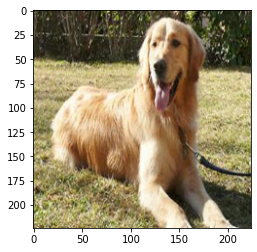

In [4]:
plt.imshow(input_batch[0].astype(np.float32))

### Preprocess Images:

PyTorch has a normalization that it applies by default in all of its pretrained vision models - we can preprocess our images to match this normalization by the following, making sure our final result is in FP16 precision:

In [5]:
import torch
from torchvision.transforms import Normalize

def preprocess_image(img):
    norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    result = norm(torch.from_numpy(img).transpose(0,2).transpose(1,2))
    return np.array(result, dtype=np.float16)

preprocessed_images = np.array([preprocess_image(image) for image in input_batch])

## 4. What TensorRT path am I using to convert my model?

We can use trtexec, a command line tool for working with TensorRT, in order to convert an ONNX model originally from PyTorch to an engine file.

Let's make sure we have TensorRT installed (this comes with trtexec):

In [6]:
import tensorrt

To convert the model we saved in the previous step, we need to point to the ONNX file, give trtexec a name to save the engine as, and last specify that we want to use a fixed batch size instead of a dynamic one.

In [7]:
# step out of Python for a moment to convert the ONNX model to a TRT engine using trtexec
if USE_FP16:
    !trtexec --onnx=resnet50_pytorch.onnx --saveEngine=resnet_engine_pytorch.trt  --explicitBatch --inputIOFormats=fp16:chw --outputIOFormats=fp16:chw --fp16
else:
    !trtexec --onnx=resnet50_pytorch.onnx --saveEngine=resnet_engine_pytorch.trt  --explicitBatch

&&&& RUNNING TensorRT.trtexec # trtexec --onnx=resnet50_pytorch.onnx --saveEngine=resnet_engine_pytorch.trt --explicitBatch --inputIOFormats=fp16:chw --outputIOFormats=fp16:chw --fp16
[06/09/2021-20:23:03] [I] === Model Options ===
[06/09/2021-20:23:03] [I] Format: ONNX
[06/09/2021-20:23:03] [I] Model: resnet50_pytorch.onnx
[06/09/2021-20:23:03] [I] Output:
[06/09/2021-20:23:03] [I] === Build Options ===
[06/09/2021-20:23:03] [I] Max batch: explicit
[06/09/2021-20:23:03] [I] Workspace: 16 MiB
[06/09/2021-20:23:03] [I] minTiming: 1
[06/09/2021-20:23:03] [I] avgTiming: 8
[06/09/2021-20:23:03] [I] Precision: FP32+FP16
[06/09/2021-20:23:03] [I] Calibration: 
[06/09/2021-20:23:03] [I] Refit: Disabled
[06/09/2021-20:23:03] [I] Safe mode: Disabled
[06/09/2021-20:23:03] [I] Save engine: resnet_engine_pytorch.trt
[06/09/2021-20:23:03] [I] Load engine: 
[06/09/2021-20:23:03] [I] Builder Cache: Enabled
[06/09/2021-20:23:03] [I] NVTX verbosity: 0
[06/09/2021-20:23:03] [I] Tactic sources: Using def

This will save our model as 'resnet_engine.trt'.

## 5. What TensorRT runtime am I targeting?

Now, we have a converted our model to a TensorRT engine. Great! That means we are ready to load it into the native Python TensorRT runtime. This runtime strikes a balance between the ease of use of the high level Python APIs used in frameworks and the fast, low level C++ runtimes available in TensorRT.

In [8]:
%%time

import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

f = open("resnet_engine_pytorch.trt", "rb")
runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING)) 

engine = runtime.deserialize_cuda_engine(f.read())
context = engine.create_execution_context()

CPU times: user 15.9 s, sys: 556 ms, total: 16.5 s
Wall time: 19.3 s


Now allocate input and output memory, give TRT pointers (bindings) to it:

In [9]:
import numpy as np

# need to set input and output precisions to FP16 to fully enable it
output = np.empty([BATCH_SIZE, 1000], dtype = target_dtype) 

# allocate device memory
d_input = cuda.mem_alloc(1 * input_batch.nbytes)
d_output = cuda.mem_alloc(1 * output.nbytes)

bindings = [int(d_input), int(d_output)]

stream = cuda.Stream()

Next, set up the prediction function.

This involves a copy from CPU RAM to GPU VRAM, executing the model, then copying the results back from GPU VRAM to CPU RAM:

In [10]:
def predict(batch): # result gets copied into output
    # transfer input data to device
    cuda.memcpy_htod_async(d_input, batch, stream)
    # execute model
    context.execute_async_v2(bindings, stream.handle, None)
    # transfer predictions back
    cuda.memcpy_dtoh_async(output, d_output, stream)
    # syncronize threads
    stream.synchronize()
    
    return output

Let's time the function!

In [12]:
print("Warming up...")

pred = predict(preprocessed_images)

print("Done warming up!")

Warming up...
Done warming up!


In [14]:
%%timeit

pred = predict(preprocessed_images)

6.28 ms ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Finally we should verify our TensorRT output is still accurate.

In [15]:
indices = (-pred[0]).argsort()[:5]
print("Class | Probability (out of 1)")
list(zip(indices, pred[0][indices]))

Class | Probability (out of 1)


[(207, 12.44), (208, 7.508), (220, 7.492), (160, 7.426), (226, 7.383)]

Look for ImageNet indices 150-275 above, where 207 is the ground truth correct class (Golden Retriever). Compare with the results of the original unoptimized model in the first section!

## Next Steps:

<h4> Profiling </h4>

This is a great next step for further optimizing and debugging models you are working on productionizing

You can find it here: https://docs.nvidia.com/deeplearning/tensorrt/best-practices/index.html

<h4>  TRT Dev Docs </h4>

Main documentation page for the ONNX, layer builder, C++, and legacy APIs

You can find it here: https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html

<h4>  TRT OSS GitHub </h4>

Contains OSS TRT components, sample applications, and plugin examples

You can find it here: https://github.com/NVIDIA/TensorRT


#### TRT Supported Layers:

https://github.com/NVIDIA/TensorRT/tree/main/samples/opensource/samplePlugin

#### TRT ONNX Plugin Example:

https://docs.nvidia.com/deeplearning/tensorrt/support-matrix/index.html#layers-precision-matrix